# **Lab 3 : DATA ANALYTICS PIPELINE USING APACHE SPARK**



## **By Priyanka Manoj Naik - 50248591**



### **Goals:**


1. Data aggregation from news source like NYTimes using the APIs exposed by data sources on four categories - Politics, Sports, Business and Travel
2. Applying classical big data analytic method of MapReduce to the unstructured data collected using Apache Spark
3. Assessing and Comparing the classification accuracy of at least two well-known classification algorithms, for a given text data set

### **Abstract:**


> Through the use of various tools, we select different categories of the news article like **Politics, Sports, Business and Travel** and collect relevant data that we subsequently explore.

> I plan on implementing this project in three parts. First and foremost, I need a data wrangling technique for which I will use python. In order to collect data from NYTimes, I will be using nytimes provided API. I will refactor the data into a predefined format and make sure to leave only relevant information within, removing stop words, links, and other unnecessary parts. I will then proceed onto the map reduce portion of the project where I shall implement the word and its frequency using **Apache Spark**. Lastly, I will split the data into train and test data set and apply three classification methods like **Multinomial Naive Bayes (Probabilistic Classifier), Extra Trees Classifier (Rule-based Classifier) and Multi-layer Perceptron (Linear Classifier)** for calculation of accuracy on test and validation data set. For visualization of the behavior of two methods, I will plot graphs for the same.


### ** Project Objectives:**


1. **Explore** the Apache Spark framework and programming: spark context (sc), dataflow operations in **transformations, actions, pipelines and MLib**.
2. **Apply** data analytics knowledge (word frequency, word-co-occurrence) and machine learning skills to perform multi-class classification of text data using Apache Spark.
3. **Build a data pipeline** using 
    1. Data from sources such as NY Times articles using the APIs provided by the data sources.
    2. Split the data into training and test data set.
    3. Extract features that will determine the class or category of the article {politics, sports, business, travel}
    4. Build a model for classification using any two of the several classification algorithms.
    5. **Assess** the accuracy using a query text or new article for each news “category”
    6. **Compare** the classification accuracy of at least two well-known classification algorithms, for a given text data set.
    
    
### **Project Approach:**


#### *Part 1:*

##### Pre-Lab

- Study the architecture, APIs, and operations of Apache Spark.
- Choose an Apache Spark environment : I chose Jupyter Notebook
- Familiarize with the dataflow, commands and the concept of Spark context. Run sample programs such as word count with Apache Spark and check if it works well with the choosen environment.

> ***Refer Notebook - NaikLab3-Pre-Lab.ipynb***

> Input Folders
> - input/input.txt


#### *Part 2:*

##### Understanding Apache Spark with Titanic data analysis

In this part of the project, we explored the titanic data set from the source [kaggle][].
[kaggle]: https://benfradet.github.io/blog/2015/12/16/Exploring-spark.ml-with-the-Titanic-Kaggle-competition

I used apache spark with python (pyspark). Through this, I learnt about dataframes in python and plotting of graphs using matplotlib library. Along with this, I learnt use of numpy for computations of data set and classification methods like Support Vector Machine using sklearns library. This knowledge of having implemented data analysis on Titanic data using Apache Spark was helpful in Part3 of the Lab.

> ***Refer Notebook - NaikLab3-Titanic.ipynb***

> *Folder Structure*

> Input Folders
> - data/train.csv
> - data/test.csv


> Output Folder
> - data/output


#### *Part 3:*

##### Build data pipeline and apply the knowledge of data analysis with Apache Spark

###### 1. Collection of Data
Data is collected from sources like NYTimes using nytimes archive api.
http://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api-key}

For the api, we need to provide api-key, year and month. I used the code for collection of the data from the previous lab with the only change of api. I changed the api from search to archive in order to retrieve more data over a period of month and year. The data gathered through this step is entire data for different categories. Since, I need to perform data analysis on 4 categories, I extracted the field "news-desk" which will specify the type of article like Sports, Politics, Business, etc. I chose following four categories - *Politics, Sports, Business and Travel*. 

> ***Refer Python Code - collect-news-data-archive.py***

The collected data is placed in the folder input-archive. The data collected is in json format. 

> Output Folder - input-archive/

In [1]:
import os, json, sys
import re
import operator
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from pyspark import SparkConf, SparkContext
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scikitplot as skplt
from IPython.display import Markdown
from sklearn.model_selection import cross_val_predict
porter = PorterStemmer()

In [2]:
# Method to get all the json files from the input folder
def get_json_files(path_to_json):
    news_files = []
    json_path = "".join([path_to_json, "/"])
    news_files.extend(str(json_path + pos_json) for pos_json in os.listdir(json_path) if pos_json.endswith('.json'))
    return news_files

# Method to read the json file and place it in the news array
def read_input(news_files):
    news = []
    for news_file in news_files:
        with open(str(news_file), 'r') as f:
            for line in f.readlines():
                news.append(json.loads(line))
    return news

# Method to extract the four categories from the collected data set
def parse_articles(news_articles):
    categoryMapping = {'Business': 0, 'Politics': 1, 'Sports': 2, 'Travel': 3}
    news = []
    if len(news_articles) >= 1:
        for articles in news_articles:
            for article in articles["response"]["docs"]:
                try:
                    if(article["news_desk"] == "Business" or article["news_desk"] == "Travel" or article["news_desk"] == "Sports" or (article["news_desk"] == "National" and article["subsection_name"] == "Politics")):
                        snippet = article["lead_paragraph"] if "lead_paragraph" in article.keys() else ""
                        if snippet is None:
                            snippet = article["snippet"] if "snippet" in article.keys() else ""
                        if snippet is not None:
                            if(article["news_desk"] == "National" and article["subsection_name"] == "Politics"):
                                news.append((snippet, categoryMapping[str(article["subsection_name"])]))
                            else:
                                news.append((snippet, categoryMapping[str(article["news_desk"])]))
                except:
                    pass
    news = sorted(news, key=lambda x:x[1])
    return news

# Method to stem the extracted news articles.
def stemmed_list(docs):
    answer = []
    for doc in docs:
        x = []
        for word in tokenize(doc[0]):
            x.append(porter.stem(word))
            stemmed_words = ' '.join(x)
        answer.append((stemmed_words, doc[1]))
    return answer

#Method to extract news articles when a set of input files are given
def get_news(file):
    news_files = get_json_files(file)
    news_articles = read_input(news_files)
    return stemmed_list(parse_articles(news_articles))

###### 2. Splitting of data, Extract top N features, Assess and Compare accuracy of two classification methods

***Extraction of Top N Features***

Extract features that will determine the class or category of the article - Politics, Sports, Business, Travel. For extraction of top N features, I splitted the training data into depending on their categories. For this, I used *split_data_on_categories* method, that will return splitted news *business_news, travel_news, sports_news, politics_news*. I need to get the top N featured for each category. In order to do so, I used Apache Spark which will process the data in a single pipeline and gives resulting features. 


*Preparation of news data :*

The main goal of this stage is to prepare news text fields for extraction of features. This stage was carried out as follows:
- Tokenizing each single word by punctuation or white space.
- Removing all stop words (Stop word corpus was taken from the NLTK website (Natural Language Toolkit Project)), such as a and the, stop words a and the have often been in use in any text, but do not include specific information required to train this data model.
- Putting all the capital letters in a lower case.
- Stemming (with Porter stemmer) and reducing inflectional forms to a stemma form.

***Data Pipeline***

![title](data-flow.png)

- **Parallelization**

> For feature extraction, I parallelized the data set using *sc.parallelize* function, passing it the data set. Parallelized collections are created by calling SparkContext’s parallelize method on an existing iterable or collection in your driver program. The elements of the collection are copied to form a distributed dataset that can be operated on in parallel. Once created, the distributed dataset (distData) can be operated on in parallel.

- **Flat Map**

> In this step, the data resulted from the parallelization step is given as input to the flat map to create tokens. The tokens retrieved from this step are filtered tokens. The data is tokenised using regular expressions, punctuations and stop words are removed, resulting words are stemmed and given to the next step. The flat map function in this case tokenises and cleans the input data.

- **Map**

> This will return a tuple with word and its count.

- **ReduceByKey**

> This will return a tuple with word and its total count in all the training data set.

- **SortBy**

> This will return a list of sorted tuples. The sorting is done on the count and in the descending order.

- **Take**

> This will return a list of words with top N words. N is given as an input to the method. Here, in this case, I have extracted 2000 features to improve the accuracy. 

All the features extracted from the spark process is combined to form a single list of vocabulary.

In [3]:
emoticons_str = r"""
    (?:
    [:=;] # Eyes
    [oO\-]? # Nose (optional)
    [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
             emoticons_str,
             r'<[^>]+>', # HTML tags
             r'(?:@[\w_]+)', # @-mentions
             r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', # hash-tags
             r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
             r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
             r'(?:[a-z][a-z\'\-_]+[a-z])', # words with - and '
             r'(?:[\w_]+)', # other words
             r'(?:\S)' # anything else
             ]

remove_regex_str = [
                    regex_str[1],
                    regex_str[2],
                    regex_str[3],
                    regex_str[4],
                    regex_str[5]
                    ]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
remove_re = re.compile(r'('+'|'.join(remove_regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation

def tokenize(s):
    tokens = tokens_re.findall(s)
    return preprocess(tokens)

def preprocess(tokens, lowercase = True):
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop and len(token) > 2]
    stemmed = [porter.stem(word) for word in filtered_tokens]
    final_words = []
    for token in stemmed:
        word = re.sub(remove_re, "", token)
        if word:
            final_words.append(word)
    return final_words

In [4]:
def split_data_on_categories(X_train, y_train):
    business_news = []
    travel_news = []
    sports_news = []
    politics_news = []
    for i in range(len(X_train)):
        news = X_train[i]
        category = y_train[i]
        if category == 0:
            business_news.append(news)
        elif category == 1:
            politics_news.append(news)
        elif category == 2:
            sports_news.append(news)
        elif category == 3:
            travel_news.append(news)
    return business_news, travel_news, sports_news, politics_news

In [5]:
def spark_process(train_data, sc):
    try:
        jsonFile = sc.parallelize(train_data)
        tokens = jsonFile.flatMap(lambda x: tokenize(x))
        mapped_tokens = tokens.map(lambda x: (x, 1))
        reduced_words = mapped_tokens.reduceByKey(lambda a,b: a + b)
        sorted_words = reduced_words.sortBy(lambda x: -x[1])
        frequent_words = [_[0] for _ in sorted_words.take(2000)]
        return frequent_words
    except:
        sc.stop()

In [6]:
def get_vocabulary(X_train, y_train):
    business_train, travel_train, sports_train, politics_train = split_data_on_categories(X_train, y_train)
    
    conf = (SparkConf().setMaster("local").setAppName("NaikLab3").set("spark.executor.memory", "1g"))
    sc = SparkContext(conf = conf)
    
    vocab_business = spark_process(business_train, sc)
    vocab_travel = spark_process(travel_train, sc)
    vocab_sports = spark_process(sports_train, sc)
    vocab_politics = spark_process(politics_train, sc)
    
    sc.stop()
    
    vocabulary = set(vocab_business + vocab_travel + vocab_sports + vocab_politics)
    return vocabulary

***Assessing Accuracy with the test data***

We learn vocabulary words from the train data set and use the data splitted to calculate the accuracy on the test data. For calculation of accuracy, I used sklearns library which provides methods like fit, fit_transform and accuracy score. 

*CountVectorizer*

> Convert a collection of text documents to a matrix of token counts. The extracted features is provided as a vocabulary to the function. 

*fit_transform*

> Learn the vocabulary dictionary and return term-document matrix. 

*fit* 

> Learn a vocabulary dictionary of all tokens in the raw documents. 

*score*

> Returns the mean accuracy on the given test data and labels. In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.

For calculation and comparison of accuracy, I have used three classification methods - ***Multinomial Naive Bayes***, ***Extra Trees Classifier*** and ***Multi-layer Perceptron***

***Mutlinomial Naive Bayes*** - Naive Bayes classifier for multinomial models

Naive Bayes classifier is a simple Statistical Bayesian Classifier (Duda & Hart, 1973). Referred to as Naïve Bayes because it assumes that all variables combine towards classification and are mutually correlated. This assumption is called class conditional independence (Friedman, 1997). They can predict class membership probabilities, such as the probability that a given data item belongs to a particular class label. A Naive Bayes classifier considers that the presence (or absence) of a particular feature (attribute) of a class is unrelated to the presence (or absence) of any other feature when the class variable is given. 

The Naive Bayes Classifier is based on Bayesian Theorem and used when the input dimensionality is high. It is a probabilistic classifier.

Multinomial Naïve Bayes is a model of NB that not only captures the presence or absence of words as in the ordinary NB classifier, but also captures the frequency of a word in a document. Multinomial Naïve Baye is more suitable for text classification as it performs better when the vocabulary size is relatively large as is usually the case of text datasets.

***Advantages***
- It is a relatively easy algorithm to build and understand.
- It is faster to predict classes using this algorithm than many other classification algorithms.
- It can be easily trained using a small data set.

***Disadvantages***
- If a given class and a feature have 0 frequency, then the conditional probability estimate for that category will come out as 0. This problem is known as  the "Zero Conditional Probability Problem." This is a problem because it wipes out all the information in other probabilities too.
- Another disadvantage is the very strong assumption of independence class features that it makes. It is near to impossible to find such data sets in real life.

In [7]:
def accuracy_Multinomial_Naive_Bayes(X_train, X_test, y_train, y_test):
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    accuracy = round(mnb.score(X_test, y_test)*100, 2)
    mnb_predictions = cross_val_predict(mnb, X_test, y_test)
    print classification_report(y_test, mnb_predictions)
    skplt.metrics.plot_confusion_matrix(y_test, mnb_predictions, normalize=True)
    mnb_probas = mnb.predict_proba(X_test)
    skplt.metrics.plot_precision_recall_curve(y_test, mnb_probas)
    skplt.metrics.plot_roc_curve(y_test, mnb_probas)
    skplt.estimators.plot_learning_curve(mnb, X_train, y_train)
    return accuracy, mnb_predictions

***Extra Trees Classifier*** - An extra-trees classifier

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

It is a rule-based classifier.

***Disadvantages***
- May overfit data
- May get stuck in local minima so need ensembles to help reduce the variance

In [8]:
def accuracy_Extra_Trees_Classifier(X_train, X_test, y_train, y_test):
    etc = ExtraTreesClassifier()
    etc.fit(X_train, y_train)
    accuracy = round(etc.score(X_test, y_test)*100, 2)
    etc_predictions = cross_val_predict(etc, X_test, y_test)
    print classification_report(y_test, etc_predictions)
    skplt.metrics.plot_confusion_matrix(y_test, etc_predictions, normalize=True)
    etc_probas = etc.predict_proba(X_test)
    skplt.metrics.plot_precision_recall_curve(y_test, etc_probas)
    skplt.metrics.plot_roc_curve(y_test, etc_probas)
    skplt.estimators.plot_learning_curve(etc, X_train, y_train)    
    return accuracy, etc_predictions

***Multi-layer Perceptron*** - Multi-layer Perceptron classifier

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function by training on a dataset, where m is the number of dimensions for input and o is the number of dimensions for output. Given a set of features X = {x_1, x_2, ..., x_m} and a target y, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. 

It is a linear classifier.

***Advantages***

- Capability to learn non-linear models.
- Capability to learn models in real-time (on-line learning) using partial_fit.

***Disadvantages***

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling.

In [9]:
def accuracy_MLP(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    mlp.fit(X_train, y_train)
    accuracy = round(mlp.score(X_test, y_test)*100, 2)
    mlp_predictions = cross_val_predict(mlp, X_test, y_test)
    print classification_report(y_test, mlp_predictions)
    skplt.metrics.plot_confusion_matrix(y_test, mlp_predictions, normalize=True)
    mlp_probas = mlp.predict_proba(X_test)
    skplt.metrics.plot_precision_recall_curve(y_test, mlp_probas)
    skplt.metrics.plot_roc_curve(y_test, mlp_probas)
    skplt.estimators.plot_learning_curve(mlp, X_train, y_train)
    return accuracy, mlp_predictions

In [10]:
news = get_news("input-archive/")
Markdown("### News Articles collected : " + str(len(news)))

### News Articles collected : 25415

***Splitting of data***

For splitting of data into train and test, I used sklearns library feature of model_selection which provides a method to split the data. 

> *from sklearn.model_selection import train_test_split*

For splitting of data - *news and categories set into train and test*, I provide a tuple with news and the categories. These are then given to the function *train_test_split*, which in turn returns a train and test for both news and their respective categories.

In [11]:
news_data = [new[0] for new in news]
categories = [new[1] for new in news]
X_train, X_test, y_train, y_test = train_test_split(news_data, categories)
Markdown("### After splitting of data set into train and test")

### After splitting of data set into train and test

In [12]:
Markdown("### Training data set size : " + str(len(X_train)))

### Training data set size : 19061

In [13]:
Markdown("### Test data set size : " + str(len(X_test)))

### Test data set size : 6354

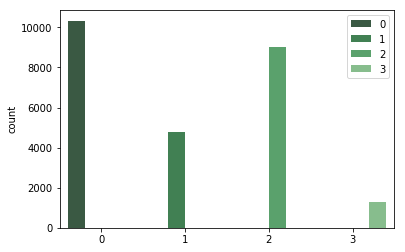

In [14]:
sns.countplot(x=categories, hue=categories, palette="Greens_d")

Index|Category
-|-
0|Business
1|Politics
2|Sports
3|Travel

In [15]:
vocabulary = get_vocabulary(X_train, y_train)
Markdown("### Features Selected for classification " + str(len(vocabulary)))

### Features Selected for classification 4289

In [16]:
DocVecRep = CountVectorizer(vocabulary=vocabulary)
X_train = DocVecRep.fit_transform(X_train).toarray()
X_test = DocVecRep.fit_transform(X_test).toarray()

             precision    recall  f1-score   support

          0       0.86      0.88      0.87      2582
          1       0.81      0.84      0.83      1188
          2       0.94      0.92      0.93      2265
          3       0.79      0.58      0.67       319

avg / total       0.87      0.87      0.87      6354



/Library/Python/2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


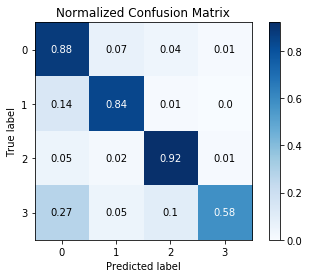

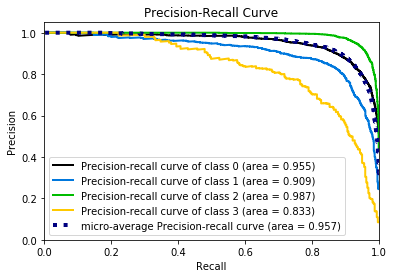

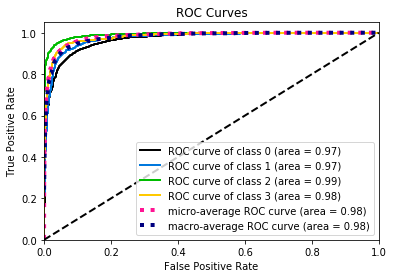

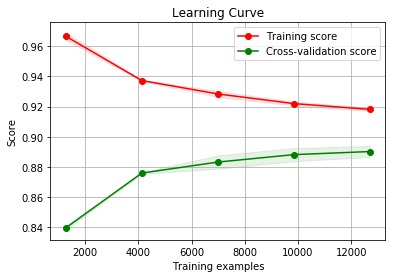

In [17]:
mnb_accuracy, mnb_predictions = accuracy_Multinomial_Naive_Bayes(X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

          0       0.80      0.85      0.82      2582
          1       0.79      0.77      0.78      1188
          2       0.88      0.89      0.89      2265
          3       0.68      0.41      0.51       319

avg / total       0.82      0.83      0.82      6354



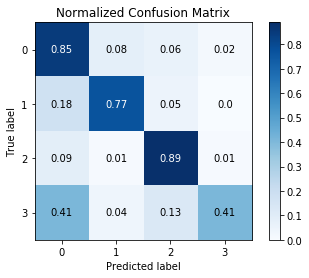

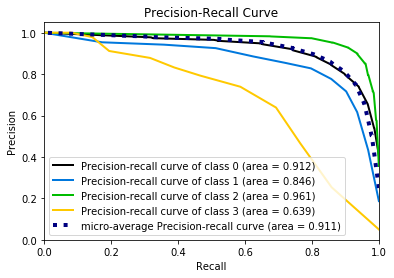

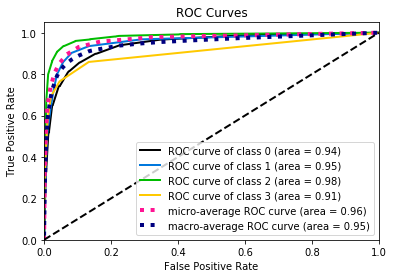

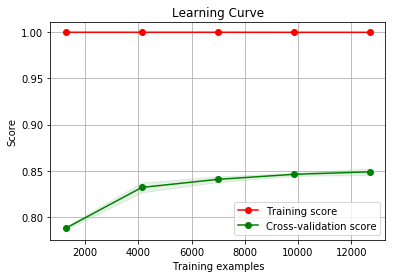

In [18]:
etc_accuracy, etc_predictions = accuracy_Extra_Trees_Classifier(X_train, X_test, y_train, y_test)

             precision    recall  f1-score   support

          0       0.76      0.81      0.78      2582
          1       0.57      0.36      0.44      1188
          2       0.88      0.86      0.87      2265
          3       0.14      0.28      0.19       319

avg / total       0.74      0.72      0.72      6354



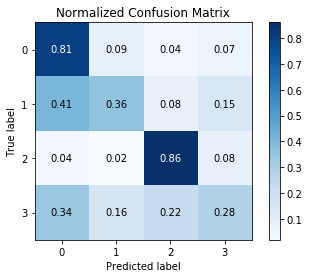

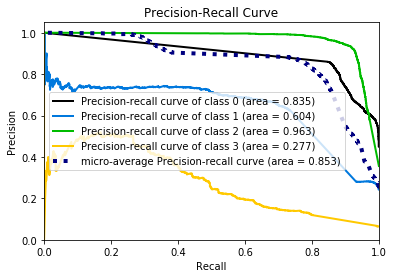

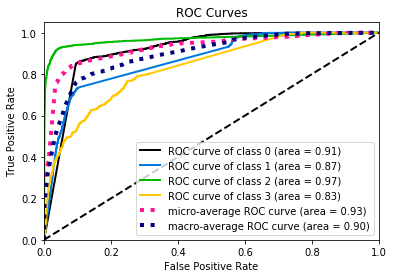

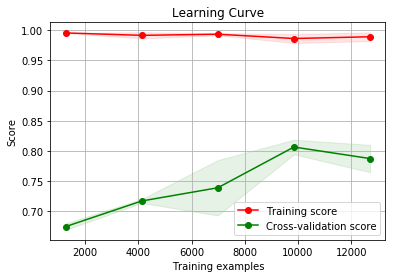

In [19]:
mlp_accuracy, mlp_predictions = accuracy_MLP(X_train, X_test, y_train, y_test)

In [20]:
Markdown("#### Multinomial Naive Bayes Accuracy = " + str(mnb_accuracy))

#### Multinomial Naive Bayes Accuracy = 89.17

In [21]:
Markdown("#### Extra Trees Classifier Accuracy = " + str(etc_accuracy))

#### Extra Trees Classifier Accuracy = 85.58

In [22]:
Markdown("#### Multi-layer Perceptron Accuracy = " + str(mlp_accuracy))

#### Multi-layer Perceptron Accuracy = 81.27

***Comparison of Model Classification Methods***

*Precision-score*

> According to Fabian Pedregosa et al (2011) precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

*Recall-score*

> According to Fabian Pedregosa et al (2011) recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.

*F1-score*

> According to Fabian Pedregosa et al (2011) F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: F1 = 2 *(precision * recall) / (precision + recall).

### If we compare the precision score, recall score and F1-score of all the algorithms stated above, Multinomial Naive Bayes performs better than other algorithms with a score of 0.88.

*Confusion Matrix:*

> A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

### In our case, if we consider the confusion created by the 4 classes, Multinomial Naive Bayes gives more accurate results. Also, Multi-layer Perceptron is more confused when it comes to classification of test data into 4 categories. Observations show that the results generated by Multi-layer Perceptron are confused for the travel category.

*Precision-Recall Curve*

> A precision-recall curve shows the relationship between precision (= positive predictive value) and recall (= sensitivity) for every possible cut-off.The precision recall area under curve (PR AUC) is just the area under the PR curve. The higher it is, the better the model is.

### Observations show that the results obtained by Multinomial Naive Bayes are good when compared to the curve obtained by Extra Trees Classifier, while it is worst in case of Multi-layer Perceptron for Travel category as it is more close to the 0.01.

*Receiver Operating Characteristic curve (ROC curve)*

> It is a plot of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.

> An ROC curve demonstrates several things:

> - It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
> - The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
> - The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
> - The area under the curve is a measure of text accuracy.

### Observations show that the results obtained by Multinomial Naive Bayes and Extra Trees Classifier are more accurate for all the 4 categories while it is worst in case of Multi-layer Perceptron for Travel category as it is more close to the 45-degree diagonal.


*Learning Curve*

> A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data. 

> We will probably have to use an estimator or a parametrization of the current estimator that can learn more complex concepts (i.e. has a lower bias). If the training score is much greater than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization. 

### In the above plot, we can see that Multinomial Naive Bayes roughly converges to a low score. Also, we can see that the Extra Tress Classifier and Multi-layer Perceptron could benefit from more training examples.

### **Conclusion:**

> I learnt about Apache Spark framework and program using spark context (sc). I also included learning of dataflow operations in transformations, actions, pipelines and MLib. Application of data analytics knowledge (word frequency, word-co-occurrence) learnt from Assignment 2 and my machine learning skills to perform multi-class classification of text data using Apache Spark.

> After applying the machine learning algorithms for classification of data set into 4 categories {Politics, Sports, Business, Travel}, the accuracy for test set came out to be around **89%**. Also, in our case, **Multinomial Naive Bayes** is **more accurate** compared to **Multilayer Perceptron and Extra Trees Classifier**. Observation also shows that MNB is very fast in building its classification model and would be preferred in real time binary classification situations but in cases where any increase in accuracy is very important and the added time taken by ensemble model can be overlooked, using an ensemble of algorithms is preferred.

### **References**

1. Analysis of Titanic data set : 
    - https://github.com/agconti/kaggle-titanic
2. PySpark :
    - http://www.learnbymarketing.com/618/pyspark-rdd-basics-examples/
    - http://www.alpha-epsilon.de/cca175/2017/09/13/filter-aggregate-join-rank-and-sort-datasets-spark-python/
    - http://spark.apache.org/examples.html
3. Model Classification : 
    - http://www.ritchieng.com/machine-learning-evaluate-classification-model/
    - http://scikit-learn.org/stable/
4. Plotting Graphs :
    - https://matplotlib.org/users/pyplot_tutorial.html
    - https://seaborn.pydata.org/tutorial/categorical.html
    - http://scikit-plot.readthedocs.io/en/stable/Quickstart.html